In [ ]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
from mudata import MuData
import numpy as np
import warnings
import os

import scirpy as ir
from cycler import cycler

from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

from palmotif import compute_motif, svg_logo
import seaborn as sb
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
ddl.logging.print_header()

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Opcional: Desactivar warnings específicos (ejemplo: FutureWarnings de anndata)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

# Si usas tqdm y deseas evitar sus warnings
from tqdm import TqdmWarning
warnings.simplefilter(action="ignore", category=TqdmWarning)

#### CARGAMOS Y PREPARAMOS LOS DATOS:

In [ ]:
# Definir las rutas de los archivos TCR para todas las muestras
samples = {
    "PT_14": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire/vdj_annotation/06-annotate-metadata/PT_14/PT_14_meta-pass.tsv",
    "PT_17": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire/vdj_annotation/06-annotate-metadata/PT_17/PT_17_meta-pass.tsv",
    "PT_20": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire/vdj_annotation/06-annotate-metadata/PT_20/PT_20_meta-pass.tsv",
    "PT_22": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire/vdj_annotation/06-annotate-metadata/PT_22/PT_22_meta-pass.tsv",
    "PT_28": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire/vdj_annotation/06-annotate-metadata/PT_28/PT_28_meta-pass.tsv",
    #"PT_14_pan_B": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire_18_41_49_50/vdj_annotation/06-annotate-metadata/PT_14_PAN_B/PT_14_PAN_B_meta-pass.tsv",
    "PT_14_pan": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire_18_41_49_50/vdj_annotation/06-annotate-metadata/PT_14_PAN_T/PT_14_PAN_T_meta-pass.tsv",
    "PT_18": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire_18_41_49_50/vdj_annotation/06-annotate-metadata/PT_18/PT_18_meta-pass.tsv",
    "PT_41": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire_18_41_49_50/vdj_annotation/06-annotate-metadata/PT_41/PT_41_meta-pass.tsv",
    "PT_49": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire_18_41_49_50/vdj_annotation/06-annotate-metadata/PT_49/PT_49_meta-pass.tsv",
    "PT_50": "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire_18_41_49_50/vdj_annotation/06-annotate-metadata/PT_50/PT_50_meta-pass.tsv"
}

# Lista para almacenar los objetos AnnData de TCR
adata_list = []

# Procesar cada archivo de TCR
for sample, path in samples.items():
    print(f"Procesando muestra: {sample}")
    
    # Cargar el archivo TCR como DataFrame
    df_tcr = pd.read_csv(path, sep="\t", encoding="utf-8")

    # Corregir la columna 'productive' si es necesario
    df_tcr["productive"] = df_tcr["productive"].astype(str)

    # Ajustar los 'cell_id' para incluir el identificador de muestra
    df_tcr["cell_id"] = df_tcr["cell_id"].str.replace(r"(\-1)", r"-1_PT" + sample[3:], regex=True)

    # Cargar el archivo TCR en un objeto AnnData con Scirpy
    adata_tcr = ir.io.read_airr(df_tcr)

    # Añadir el metadato 'sample' para identificar la muestra
    adata_tcr.obs["sample"] = sample

    # Añadir el objeto adata_tcr a la lista
    adata_list.append(adata_tcr)

# Concatenar todos los objetos AnnData de TCR en un único objeto
adata_combined = ad.concat(adata_list, axis=0, join="outer", keys=samples.keys())

# Mostrar la información del objeto combinado
print(adata_combined)

In [ ]:
for sample, adata_tcr in zip(samples.keys(), adata_list):
    print(f"Muestra: {sample}, Número de células: {adata_tcr.n_obs}")


Vamos a probar el PT_14 estudiar un poco su estructura:

In [ ]:
# Ruta del archivo de TCR del paciente PT_14
path_tcr = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Analisis_repertorio/Results_repertoire/vdj_annotation/06-annotate-metadata/PT_14/PT_14_meta-pass.tsv"

# Cargar el archivo de TCR como DataFrame
df_tcr = pd.read_csv(path_tcr, sep="\t", encoding="utf-8")

# Filtrar las columnas necesarias
required_columns = [
    "sequence_id", "sequence", "rev_comp", "productive", "vj_in_frame", "stop_codon", 
    "locus", "v_call", "d_call", "j_call", "c_call", "sequence_alignment", 
    "germline_alignment", "junction", "junction_aa", "cdr1", "cdr2", "cdr3", 
    "fwr1", "fwr2", "fwr3", "fwr4", "v_score", "v_identity", "v_support", 
    "v_cigar", "d_score", "d_identity", "d_support", "d_cigar", "j_score", 
    "j_identity", "j_support", "j_cigar", "v_sequence_start", "v_sequence_end", 
    "v_germline_start", "v_germline_end", "d_sequence_start", "d_sequence_end", 
    "d_germline_start", "d_germline_end", "j_sequence_start", "j_sequence_end", 
    "j_germline_start", "j_germline_end", "junction_length", "np1_length", 
    "np2_length", "consensus_count", "duplicate_count", "cell_id"
]
df_tcr = df_tcr[required_columns]

# Corregir la columna 'productive' si es necesario
df_tcr["productive"] = df_tcr["productive"].astype(str)

# Modificar el formato de los 'cell_id' para que coincidan con el GEX
df_tcr["cell_id"] = df_tcr["cell_id"].str.replace(r"(\-1)", r"-1_PT14", regex=True)

# Crear un objeto AnnData con Scirpy
adata_pt14 = ir.io.read_airr(df_tcr)

# Añadir el metadato 'sample'
adata_pt14.obs["sample"] = "PT_14"

In [ ]:
import awkward as ak
# Convertir obsm["airr"] en un DataFrame de pandas
airr_data = ak.to_dataframe(adata_pt14.obsm["airr"])
airr_data

In [ ]:
adata_gex = ad.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/adata_concatenados_10_pt.h5ad")

In [ ]:
# Ahora combinamos los datos en un MuData
mdata2 = MuData({"gex": adata_gex, "airr": adata_combined})

In [ ]:
gex_barcodes = adata_gex.obs_names
airr_barcodes = adata_combined.obs_names

# Intersección de barcodes
intersecting_barcodes = set(gex_barcodes).intersection(set(airr_barcodes))
print(f"Total de barcodes en GEX: {len(gex_barcodes)}")
print(f"Total de barcodes en AIRR: {len(airr_barcodes)}")
print(f"Barcodes compartidos: {len(intersecting_barcodes)}")

In [ ]:
# Porcentaje de células en GEX con datos de TCR
percentage_gex_with_tcr = (len(intersecting_barcodes) / len(gex_barcodes)) * 100
print(f"Porcentaje de células en GEX con datos de TCR: {percentage_gex_with_tcr:.2f}%")

In [ ]:
# Guardar el MuData concatenado
output_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/mudata_10pts_TCR.h5mu"
mdata2.write(output_path)

### ANALISIS REPERTORIO

In [120]:
mdata = mu.read_h5mu("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/mudata_10pts_TCR.h5mu")

In [121]:
# Identificar las células comunes entre 'gex' y 'airr'
common_cells = mdata["gex"].obs_names.intersection(mdata["airr"].obs_names)

# Contar las células en 'gex' que NO están en 'airr'
cells_without_tcr = np.setdiff1d(mdata["gex"].obs_names, common_cells)

# Calcular el porcentaje de células sin TCR en 'gex'
percent_without_tcr_gex = 100 * len(cells_without_tcr) / len(mdata["gex"].obs_names)

# Calcular el número de células con TCR en 'gex' (las que están en ambas modalidades)
num_cells_with_tcr = len(common_cells)

# Imprimir los resultados
print(f"Porcentaje de células sin TCR en gex: {percent_without_tcr_gex:.2f}%")
print(f"Número de células con TCR en gex: {num_cells_with_tcr}")
print(f"Número de células sin TCR en gex: {len(cells_without_tcr)}")


Porcentaje de células sin TCR en gex: 7.14%
Número de células con TCR en gex: 49718
Número de células sin TCR en gex: 3824


In [122]:
mdata

MuData object with n_obs × n_vars = 60456 × 23209
  2 modalities
    gex:	53542 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	56632 x 0
      obs:	'sample'
      obsm:	'airr'

ELIMINAMOS CÉLULAS SIN TCR:

In [123]:
# Filtrar el objeto MuData para conservar solo las células con TCR
mdata_filtrado = mdata[common_cells, :]

# Verificar las dimensiones del objeto filtrado
print(f"Objeto MuData filtrado con n_obs × n_vars = {mdata_filtrado.n_obs} × {mdata_filtrado.n_vars}")
for modality in mdata_filtrado.mod.keys():
    print(f"  {modality}: {mdata_filtrado[modality].n_obs} x {mdata_filtrado[modality].n_vars}")

Objeto MuData filtrado con n_obs × n_vars = 49718 × 23209
  gex: 49718 x 23209
  airr: 49718 x 0


In [124]:
mdata_filtrado.write_h5mu("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_filtered.h5mu")

# Analisis Clonotipos

In [73]:
mdata_filtrado=mu.read_h5mu("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_filtered.h5mu")

In [74]:
mdata = mdata_filtrado.copy()

In [75]:
mdata

MuData object with n_obs × n_vars = 49718 × 23209
  2 modalities
    gex:	49718 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	49718 x 0
      obs:	'sample'
      obsm:	'airr'

In [76]:
ir.pp.index_chains(mdata)

In [77]:
ir.tl.chain_qc(mdata)

Se usan ambas cadenas (α & β) para asignar el clonotipo?
Sí. Cuando definimos clonotipos a partir de un TCR completo (α y β), Scirpy por defecto requiere que coincidan todas las cadenas que tenga cada célula. Por ejemplo:

Célula A: tiene TCRα = A1 y TCRβ = B1
Célula B: tiene TCRα = A1 y TCRβ = B1
Estas dos células serán el mismo clonotipo si coincide la CDR3 de α y β (y en caso de que compares por nt, también las secuencias nucleotídicas).

¿Y qué pasa con células que tienen una sola cadena?
Célula C: tiene solo TCRβ = B1
Célula D: tiene solo TCRα = A1
Por defecto, Scirpy agrupa células juntas solo si coinciden todas las cadenas disponibles. Si una célula no tiene la cadena α, y el clonotipo completo en principio estaba definido por α+β, Scirpy necesita que actives la opción de “partial chains matching” (parámetro partial=False/True) para que Scirpy decida si una célula con solo la cadena β (B1) puede asignarse al clonotipo que está definido por (A1, B1).

Con la configuración estándar (partial=False), Scirpy solo agrupará células que tengan exactamente las mismas cadenas presentes.
Si le pones partial=True, entonces Scirpy puede “relajar” la asignación y considerar que una célula con B1 “encaja” en el clonotipo que está definido por (A1, B1). Esto, desde luego, puede ser discutible en términos biológicos, pero Scirpy te da la posibilidad.

In [10]:
ir.pp.ir_dist(mdata,
              sequence="nt", # Comparar CDR3 a nivel de nucleótidos
              metric='identity' # Coincidencia exacta
             )

Para permitir que una célula con solo TCRβ se agrupe con un clonotipo que tiene α+β (coincidiendo al menos la β), hay que habilitar la coincidencia parcial

Esto indica que, si la célula con solo TCRβ coincide con el TCRβ de un clon α+β, se considerará parte del mismo clonotipo.

In [23]:
ir.tl.define_clonotypes(
    mdata,
    receptor_arms="any",  # Permite clonotipos con una sola cadena
    dual_ir="any",        # No restringir a una sola cadena principal
    same_v_gene=False,    # No exigir el mismo V-gene
    key_added="clone_id",
    inplace=True
)

Vamos a inspeccionar el Repertorio:

In [ ]:
airr_df = ir.get.airr(mdata, airr_variable=["sequence_id", "locus", "cdr3", "consensus_count", "duplicate_count"])
airr_df

In [25]:
# Acceder a los clonotipos y sus tamaños
clone_info = mdata["airr"].obs[["clone_id", "clone_id_size", "sample", "receptor_type", "receptor_subtype", "chain_pairing"]]

# Mostrar las primeras filas del DataFrame con la información de clonotipos
clone_info

,clone_id,clone_id_size,sample,receptor_type,receptor_subtype,chain_pairing
cell_id,,,,,,
AAACCTGAGAAGAAGC-1_PT14,0,39,PT_14,TCR,TRA+TRB,single pair
AAACCTGAGGACAGAA-1_PT14,1,7,PT_14,TCR,TRA+TRB,single pair
AAACCTGAGTGGAGTC-1_PT14,2,1,PT_14,TCR,TRA+TRB,single pair
AAACCTGAGTGTCTCA-1_PT14,3,1,PT_14,TCR,TRA+TRB,single pair
AAACCTGCAAACTGTC-1_PT14,4,1,PT_14,TCR,TRA+TRB,extra VJ
...,...,...,...,...,...,...
TTTGTCAGTGTGGCTC-1_PT50,17116,80,PT_50,TCR,TRA+TRB,single pair
TTTGTCATCGTGGGAA-1_PT50,17112,246,PT_50,TCR,TRA+TRB,single pair
TTTGTCATCTGCTGCT-1_PT50,17385,17,PT_50,TCR,TRA+TRB,single pair


## Queremos saber si comparten orphan VDJ o VJ con algun single pair:

In [26]:
clone_info = mdata["airr"].obs[
    ["clone_id", "clone_id_size", "chain_pairing"]
].copy()

group_df = (
    clone_info
    .groupby(["clone_id", "chain_pairing"])
    .size()
    .rename("count")
    .reset_index()
)
group_df.head()

,clone_id,chain_pairing,count
0,0,extra VDJ,1
1,0,extra VJ,2
2,0,orphan VDJ,9
3,0,orphan VJ,1
4,0,single pair,26


In [27]:
pivot_df = group_df.pivot(
    index="clone_id",
    columns="chain_pairing",
    values="count"
).fillna(0)
pivot_df.head()

chain_pairing,extra VDJ,extra VJ,orphan VDJ,orphan VJ,single pair,two full chains
clone_id,,,,,,
0,1.0,2.0,9.0,1.0,26.0,0.0
1,0.0,3.0,3.0,0.0,1.0,0.0
10,0.0,0.0,0.0,0.0,3.0,0.0
100,0.0,0.0,2.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
# Ejemplo: ¿clone_id con "orphan VDJ" y "single pair" > 0?
if "orphan VDJ" in pivot_df.columns and "single pair" in pivot_df.columns:
    has_both_df = pivot_df[
        (pivot_df["orphan VDJ"] > 0) & (pivot_df["single pair"] > 0)
    ]
    
else:
    print("No hay columnas 'orphan VDJ' o 'single pair' en la tabla.")

has_both_df

chain_pairing,extra VDJ,extra VJ,orphan VDJ,orphan VJ,single pair,two full chains
clone_id,,,,,,
0,1.0,2.0,9.0,1.0,26.0,0.0
1,0.0,3.0,3.0,0.0,1.0,0.0
10007,0.0,0.0,1.0,0.0,1.0,0.0
1005,0.0,0.0,2.0,0.0,1.0,0.0
1007,0.0,0.0,1.0,0.0,4.0,0.0
...,...,...,...,...,...,...
9841,0.0,0.0,1.0,0.0,1.0,0.0
9892,0.0,0.0,1.0,0.0,1.0,0.0
9920,0.0,0.0,1.0,0.0,1.0,0.0


In [31]:
if "orphan VJ" in pivot_df.columns and "single pair" in pivot_df.columns:
    has_both_df_vj = pivot_df[
        (pivot_df["orphan VJ"] > 0) & (pivot_df["single pair"] > 0)
    ]
    has_both_df_vj
else:
    print("No hay columnas 'orphan VJ' o 'single pair' en la tabla.")

has_both_df_vj

chain_pairing,extra VDJ,extra VJ,orphan VDJ,orphan VJ,single pair,two full chains
clone_id,,,,,,
0,1.0,2.0,9.0,1.0,26.0,0.0
1019,0.0,0.0,1.0,1.0,1.0,0.0
10216,0.0,0.0,0.0,1.0,1.0,0.0
10328,33.0,1.0,313.0,1.0,438.0,1.0
10337,1.0,1.0,13.0,2.0,97.0,0.0
...,...,...,...,...,...,...
9284,0.0,0.0,0.0,1.0,1.0,0.0
9342,0.0,0.0,0.0,1.0,1.0,0.0
9444,0.0,0.0,0.0,1.0,2.0,0.0


### Diagrama de Venn que comparte todo con todo:

In [ ]:
import matplotlib.pyplot as plt
from venn import venn

# Definir los grupos de interés
groups = {
    "Single Pair": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "single pair", "clone_id"].dropna()),
    "Extra VJ/VDJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"].isin(["extra VJ", "extra VDJ"]), "clone_id"].dropna()),
    "Two Full Chains": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "two full chains", "clone_id"].dropna()),
    "Orphan VJ/VDJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"].isin(["orphan VJ", "orphan VDJ"]), "clone_id"].dropna()),
}

# Graficar diagrama de Venn de 4 conjuntos
plt.figure(figsize=(8, 8))
venn(groups)
plt.title("Diagrama de Venn de clone_id entre grupos de chain_pairing")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from venn import venn

# Definir los grupos de interés con separación de orphan VJ y orphan VDJ
groups = {
    "Single Pair": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "single pair", "clone_id"].dropna()),
    "Extra VJ/VDJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"].isin(["extra VJ", "extra VDJ"]), "clone_id"].dropna()),
    "Two Full Chains": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "two full chains", "clone_id"].dropna()),
    "Orphan VJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "orphan VJ", "clone_id"].dropna()),
    "Orphan VDJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "orphan VDJ", "clone_id"].dropna()),
}

# Graficar diagrama de Venn de 5 conjuntos
plt.figure(figsize=(8, 8))
venn(groups)
plt.title("Diagrama de Venn de clone_id entre grupos de chain_pairing (Orphan VJ y Orphan VDJ separados)")
plt.show()


In [38]:
# Definir los grupos de interés basados en la tabla pivot_df
single_pair = set(pivot_df.loc[pivot_df["single pair"] > 0].index)
extra_vj_vdj = set(pivot_df.loc[(pivot_df["extra VJ"] > 0) | (pivot_df["extra VDJ"] > 0)].index)
two_full_chains = set(pivot_df.loc[pivot_df["two full chains"] > 0].index)
orphan_vj = set(pivot_df.loc[pivot_df["orphan VJ"] > 0].index)
orphan_vdj = set(pivot_df.loc[pivot_df["orphan VDJ"] > 0].index)

# Calcular intersecciones de Orphan VJ con los demás grupos
vj_single_pair = orphan_vj & single_pair
vj_extra_vj_vdj = orphan_vj & extra_vj_vdj
vj_two_full_chains = orphan_vj & two_full_chains
vj_orphan_vdj = orphan_vj & orphan_vdj

# Mostrar los números de intersección
vj_intersections = {
    "Orphan VJ ∩ Single Pair": len(vj_single_pair),
    "Orphan VJ ∩ Extra VJ/VDJ": len(vj_extra_vj_vdj),
    "Orphan VJ ∩ Two Full Chains": len(vj_two_full_chains),
    "Orphan VJ ∩ Orphan VDJ": len(vj_orphan_vdj)
}
vj_intersections

{'Orphan VJ ∩ Single Pair': 251,
 'Orphan VJ ∩ Extra VJ/VDJ': 80,
 'Orphan VJ ∩ Two Full Chains': 13,
 'Orphan VJ ∩ Orphan VDJ': 120}

## Hacemos lo mismo pero quitamos primero el orphan VJ:

In [32]:
mdata_filtrado=mu.read_h5mu("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_filtered.h5mu")

In [33]:
mdata = mdata_filtrado.copy()

In [34]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

In [35]:
# 🔹 Obtener índices de células que NO son orphan VJ en AIRR
cells_to_keep = mdata["airr"].obs.index[mdata["airr"].obs["chain_pairing"] != "orphan VJ"]

# 🔹 Filtrar solo la modalidad AIRR, dejando GEX intacto
mdata.mod["airr"] = mdata["airr"][cells_to_keep]

# 🔹 Asegurar que GEX solo contiene las células que aún están en AIRR
mdata.mod["gex"] = mdata["gex"][cells_to_keep]

# 🔹 Obtener las células presentes en ambas modalidades después del filtrado
common_cells = mdata["airr"].obs.index.intersection(mdata["gex"].obs.index)

# 🔹 Aplicar el filtrado final al objeto MuData completo
mdata = mdata[common_cells, :]

# 🔹 Verificar la estructura final
print(mdata)

View of MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'


In [36]:
ir.pp.ir_dist(
    mdata,
    sequence="nt",  # Comparación a nivel de nucleótidos
    metric="identity",  # Solo secuencias 100% idénticas se consideran iguales
    cutoff=0,  # Asegura coincidencia exacta
    inplace=True
)

In [37]:
ir.tl.define_clonotypes(
    mdata,  # Solo células bien estructuradas
    receptor_arms="all",  # Tanto VJ como VDJ deben coincidir
    dual_ir="primary_only",  #only consider most abundant pair of VJ/VDJ chains
    same_v_gene=True, #debe coincidir CDR1 y CDR2 alfa y beta tambien
    key_added="clone_id",
    inplace=True
)

In [38]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id'
      obsm:	'airr', 'chain_indices'

## Recuperamos los orphan VDJ:

In [39]:
# Obtener todas las secuencias relevantes desde Scirpy
airr_df = ir.get.airr(mdata, airr_variable=["cdr1", "cdr2", "cdr3"])
print("Columnas disponibles en airr_df:", airr_df.columns.tolist())


Columnas disponibles en airr_df: ['VJ_1_cdr1', 'VJ_1_cdr2', 'VJ_1_cdr3', 'VDJ_1_cdr1', 'VDJ_1_cdr2', 'VDJ_1_cdr3', 'VJ_2_cdr1', 'VJ_2_cdr2', 'VJ_2_cdr3', 'VDJ_2_cdr1', 'VDJ_2_cdr2', 'VDJ_2_cdr3']


In [40]:
# 🔹 Obtener todas las secuencias relevantes desde Scirpy
airr_df = ir.get.airr(mdata, airr_variable=["cdr1", "cdr2", "cdr3"])
print("Columnas disponibles en airr_df:", airr_df.columns.tolist())

# 🔹 Unimos el airr_df con la información de clonotipos en mdata["airr"].obs
clone_data = mdata["airr"].obs[['clone_id', 'chain_pairing']].copy()
clone_data = clone_data.merge(airr_df, left_index=True, right_index=True, how="left")

# 🔹 Filtramos solo las células que NO son orphan VDJ
clone_table = clone_data.query("chain_pairing in ['single pair', 'extra VJ', 'extra VDJ', 'two full chains']")

# 🔹 Seleccionar solo las columnas necesarias, incluyendo ambas cadenas VDJ_1 y VDJ_2
cdr_columns = ['VDJ_1_cdr1', 'VDJ_1_cdr2', 'VDJ_1_cdr3', 'VDJ_2_cdr1', 'VDJ_2_cdr2', 'VDJ_2_cdr3']
cdr_columns = [col for col in cdr_columns if col in clone_table.columns]  # Verificar si existen

clone_table = clone_table[['clone_id'] + cdr_columns].dropna()
print("Columnas en clone_table después de la corrección:", clone_table.columns.tolist())

# 🔹 Crear un diccionario con las secuencias CDR1+CDR2+CDR3 como clave y el clone_id como valor
cdr_to_clone = {}

for idx, row in clone_table.iterrows():
    key_1 = tuple(str(row[col]).strip() for col in ['VDJ_1_cdr1', 'VDJ_1_cdr2', 'VDJ_1_cdr3'])  # Primera cadena
    key_2 = tuple(str(row[col]).strip() for col in ['VDJ_2_cdr1', 'VDJ_2_cdr2', 'VDJ_2_cdr3']) if 'VDJ_2_cdr1' in clone_table.columns else None  # Segunda cadena

    clone_id = row['clone_id']

    # Guardamos en el diccionario solo si la clave no tiene valores None
    if all(key_1) and key_1 not in cdr_to_clone:
        cdr_to_clone[key_1] = clone_id
    if key_2 and all(key_2) and key_2 not in cdr_to_clone:
        cdr_to_clone[key_2] = clone_id

# 🔹 Filtramos solo las células orphan VDJ
orphan_vdj_cells = clone_data.query("chain_pairing == 'orphan VDJ'")

# 🔹 Reasignamos solo orphan VDJ si coinciden EXACTAMENTE con VDJ_1 o VDJ_2 de un clon ya asignado
reasignados_count = 0

for idx, row in orphan_vdj_cells.iterrows():
    key_1 = tuple(str(row[col]).strip() for col in ['VDJ_1_cdr1', 'VDJ_1_cdr2', 'VDJ_1_cdr3'])
    key_2 = tuple(str(row[col]).strip() for col in ['VDJ_2_cdr1', 'VDJ_2_cdr2', 'VDJ_2_cdr3']) if 'VDJ_2_cdr1' in orphan_vdj_cells.columns else None

    # Solo reasignamos si el CDR1, CDR2 y CDR3 coinciden exactamente
    new_clone_id = cdr_to_clone.get(key_1) or (cdr_to_clone.get(key_2) if key_2 else None)

    if new_clone_id:
        mdata["airr"].obs.at[idx, "clone_id"] = new_clone_id
        reasignados_count += 1

# 🔹 Verificamos cuántos orphan VDJ fueron reasignados
print(f"✅ Se reasignaron {reasignados_count} células orphan VDJ correctamente.")


Columnas disponibles en airr_df: ['VJ_1_cdr1', 'VJ_1_cdr2', 'VJ_1_cdr3', 'VDJ_1_cdr1', 'VDJ_1_cdr2', 'VDJ_1_cdr3', 'VJ_2_cdr1', 'VJ_2_cdr2', 'VJ_2_cdr3', 'VDJ_2_cdr1', 'VDJ_2_cdr2', 'VDJ_2_cdr3']
Columnas en clone_table después de la corrección: ['clone_id', 'VDJ_1_cdr1', 'VDJ_1_cdr2', 'VDJ_1_cdr3', 'VDJ_2_cdr1', 'VDJ_2_cdr2', 'VDJ_2_cdr3']
✅ Se reasignaron 2105 células orphan VDJ correctamente.


Para comprobar las que tienen mas de dos cadenas si coincide en VDJ:

<Figure size 800x800 with 0 Axes>

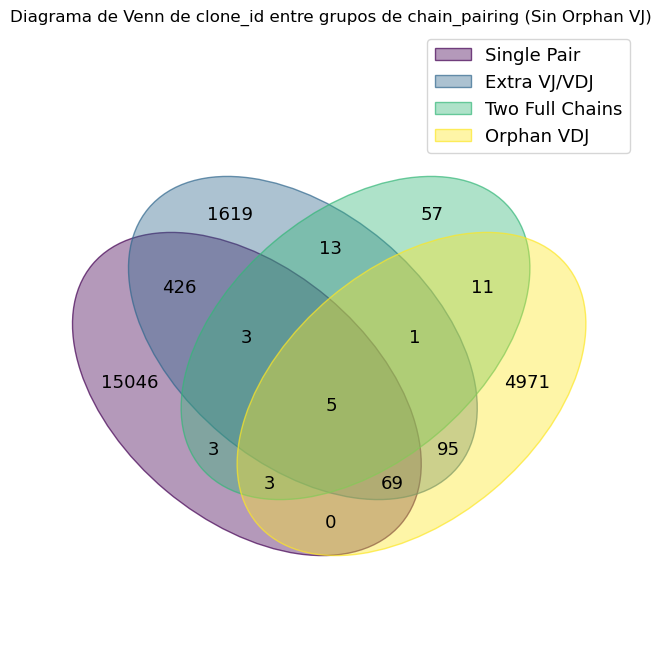

In [41]:
import matplotlib.pyplot as plt
from venn import venn

# Definir los grupos de interés SIN "Orphan VJ"
groups = {
    "Single Pair": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "single pair", "clone_id"].dropna()),
    "Extra VJ/VDJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"].isin(["extra VJ", "extra VDJ"]), "clone_id"].dropna()),
    "Two Full Chains": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "two full chains", "clone_id"].dropna()),
    "Orphan VDJ": set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "orphan VDJ", "clone_id"].dropna()),
}

# Graficar diagrama de Venn de 4 conjuntos sin "Orphan VJ"
plt.figure(figsize=(8, 8))
venn(groups)
plt.title("Diagrama de Venn de clone_id entre grupos de chain_pairing (Sin Orphan VJ)")
plt.show()

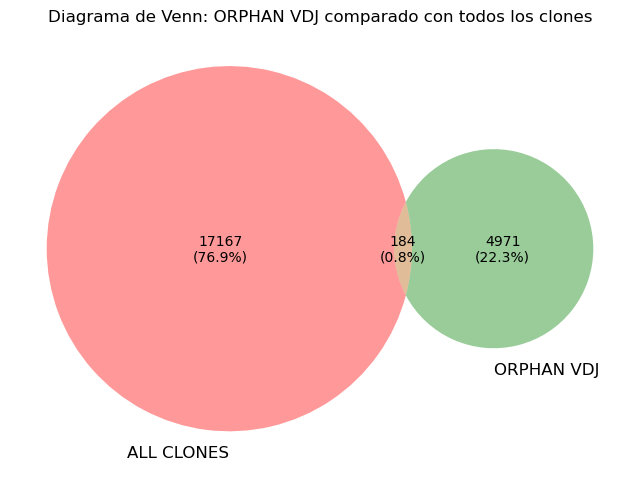

In [42]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Definir los grupos de interés:
# "ALL CLONES" = Single Pair + Extra VJ/VDJ + Two Full Chains
# "ORPHAN VDJ" = Todos los Orphan VDJ

all_clones = (
    set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "single pair", "clone_id"].dropna()) |
    set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"].isin(["extra VJ", "extra VDJ"]), "clone_id"].dropna()) |
    set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "two full chains", "clone_id"].dropna())
)

orphan_vdj = set(mdata["airr"].obs.loc[mdata["airr"].obs["chain_pairing"] == "orphan VDJ", "clone_id"].dropna())

# Calcular intersecciones
intersection = all_clones & orphan_vdj
only_all_clones = all_clones - orphan_vdj
only_orphan_vdj = orphan_vdj - all_clones

# Calcular porcentajes
total = len(all_clones | orphan_vdj)
perc_all_clones = len(only_all_clones) / total * 100
perc_orphan_vdj = len(only_orphan_vdj) / total * 100
perc_intersection = len(intersection) / total * 100

# Crear diagrama de Venn de 2 conjuntos con % debajo del número
plt.figure(figsize=(8, 8))
venn = venn2([all_clones, orphan_vdj], ('ALL CLONES', 'ORPHAN VDJ'))

# Agregar los valores numéricos y porcentajes
if venn.get_label_by_id("10"):
    venn.get_label_by_id("10").set_text(f"{len(only_all_clones)}\n({perc_all_clones:.1f}%)")
if venn.get_label_by_id("01"):
    venn.get_label_by_id("01").set_text(f"{len(only_orphan_vdj)}\n({perc_orphan_vdj:.1f}%)")
if venn.get_label_by_id("11"):
    venn.get_label_by_id("11").set_text(f"{len(intersection)}\n({perc_intersection:.1f}%)")

plt.title("Diagrama de Venn: ORPHAN VDJ comparado con todos los clones")
plt.show()



## Continuamos con el análisis:

<Axes: title={'center': 'Fraction of chain_pairing in each sample'}, xlabel='sample', ylabel='Fraction of cells in chain_pairing'>

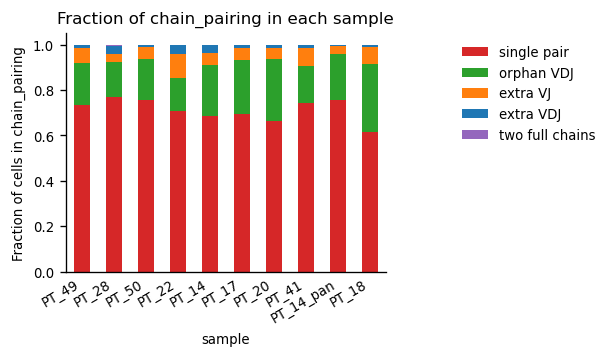

In [59]:
ir.pl.group_abundance(mdata["airr"], groupby="sample", target_col="chain_pairing", normalize=True)

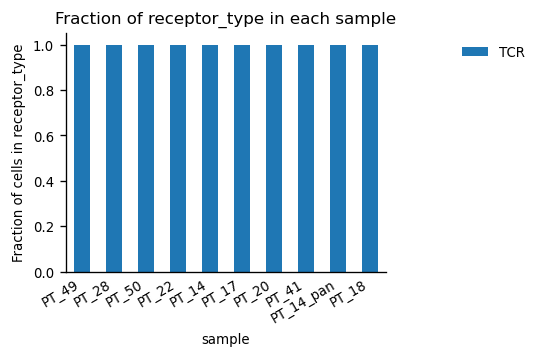

In [22]:
# Visualizar la abundancia de receptor_type por muestra
_ = ir.pl.group_abundance(
    mdata["airr"],  # Trabajamos en la modalidad de TCR
    groupby="sample",  # Agrupar por las muestras en tu dataset
    target_col="receptor_type",  # Columna que indica el tipo de receptor
    normalize=True  # Normalizar para mostrar fracciones en lugar de conteos absolutos
)

plt.show()

In [23]:
mdata["airr"].obs["chain_pairing"].value_counts()

chain_pairing
single pair        35316
orphan VDJ          9592
extra VJ            2993
extra VDJ           1029
two full chains      113
Name: count, dtype: int64

Las siguientes categorías no se encontraron en 'chain_pairing' y serán omitidas: ['orphan VJ']

Distribución de chain_pairing (números):
chain_pairing  extra VDJ  extra VJ  orphan VDJ  single pair  two full chains
Sample                                                                      
PT_14                188       312        1310         3946               18
PT_17                 77       315        1374         3998                4
PT_20                 88       260        1575         3828                8
PT_22                229       643         900         4289               14
PT_28                224       238         985         4999               38
PT_18                  3        20          83          169                0
PT_14_pan             10        43         257          951                0
PT_41                 54       376         744         3445               13
PT_49                 90       466        1275         5092               11
PT_50           

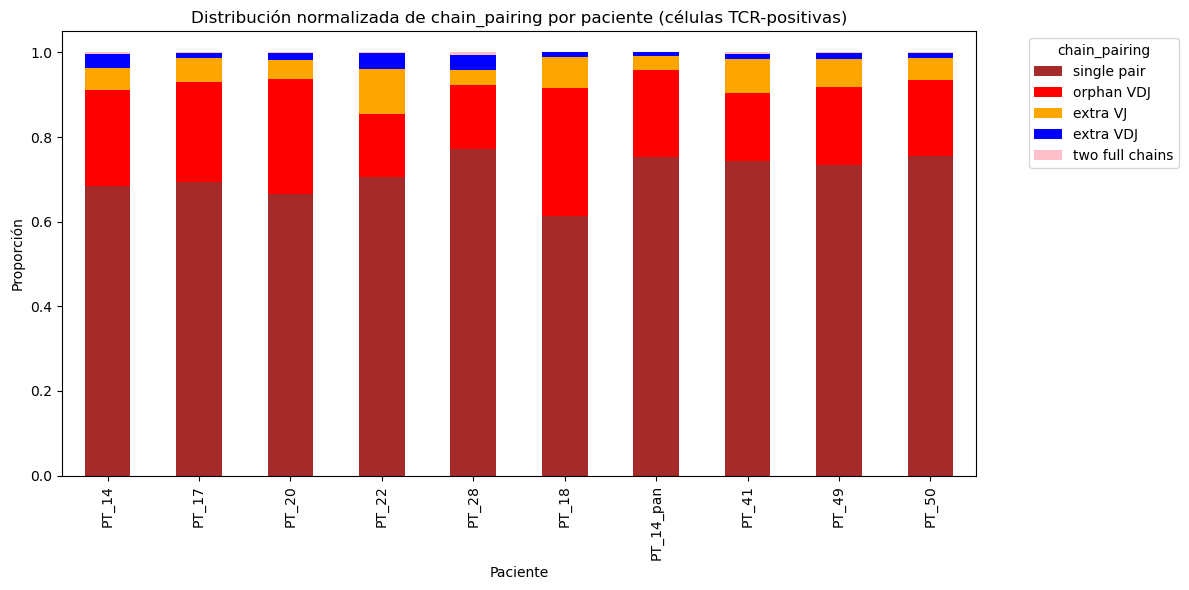

In [24]:
# Extraer las observaciones de GEX y AIRR
gex_obs = mdata["gex"].obs
airr_obs = mdata["airr"].obs

# Unir ambas capas basándonos en el índice (cell_id)
combined_df = gex_obs.join(airr_obs, how="left")

# Todas las células tienen TCR_present=True
combined_df["TCR_present"] = True

# Calcular el número de células en cada categoría de 'chain_pairing' por paciente
chain_pairing_counts = combined_df.groupby(["Sample", "chain_pairing"]).size().unstack(fill_value=0)

# Calcular proporciones
chain_pairing_proportions = chain_pairing_counts.div(chain_pairing_counts.sum(axis=1), axis=0)

# Definir el orden de categorías
category_order = [
    "single pair", 
    "orphan VDJ", 
    "extra VJ", 
    "extra VDJ", 
    "orphan VJ", 
    "two full chains"
]

# Asegurarse de que todas las categorías estén presentes
available_categories = [cat for cat in category_order if cat in chain_pairing_proportions.columns]
missing_categories = [cat for cat in category_order if cat not in chain_pairing_proportions.columns]

if missing_categories:
    print(f"Las siguientes categorías no se encontraron en 'chain_pairing' y serán omitidas: {missing_categories}")

# Ajustar category_order para solo incluir categorías disponibles
category_order = available_categories

# Reordenar las columnas según category_order
chain_pairing_proportions = chain_pairing_proportions[category_order]

# Mostrar las tablas (opcional)
print("\nDistribución de chain_pairing (números):")
print(chain_pairing_counts)

print("\nDistribución de chain_pairing (proporciones):")
print(chain_pairing_proportions)

# Definir colores para las categorías disponibles
color_map = {
    "single pair": "brown",
    "orphan VDJ": "red",
    "extra VJ": "orange",
    "extra VDJ": "blue",
    "orphan VJ": "purple",
    "two full chains": "pink"
}

# Generar la lista de colores basada en available_categories
colors = [color_map.get(cat, "gray") for cat in category_order]

# Crear la gráfica de barras apiladas
ax = chain_pairing_proportions.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12, 6), 
    color=colors
)

plt.title("Distribución normalizada de chain_pairing por paciente (células TCR-positivas)")
plt.xlabel("Paciente")
plt.ylabel("Proporción")
plt.legend(title="chain_pairing", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [25]:
# Calcular la proporción de cada tipo de 'chain_pairing' y convertir a porcentaje
chain_pairing_counts_percentage = mdata["airr"].obs["chain_pairing"].value_counts(normalize=True) * 100

# Mostrar las proporciones en porcentaje
print(chain_pairing_counts_percentage)

chain_pairing
single pair        72.010277
orphan VDJ         19.558347
extra VJ            6.102808
extra VDJ           2.098159
two full chains     0.230410
Name: proportion, dtype: float64


In [ ]:
mdata

In [ ]:
# Guardar el objeto MuData en un archivo .h5mu
mdata.write("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_intersected.h5mu")

### Expansion clonal

In [43]:
ir.tl.clonal_expansion(
    mdata, 
    expanded_in="sample",  # Expandir dentro de cada muestra
    breakpoints=(1, 10, 50, 100, 200, 500),
    target_col="clone_id"  # 🔹 Indica que el conteo se hace por clonotipo
)

#### ESTO HA FUNCIONADO MAL, POR DIVERSAS COMPROBACIONES.

Lo hacemos a mano, al recuperar orphan VDJ cuenta por chain_pairs y no por clone_id

In [44]:
# 🔹 Contar el número total de células para cada `clone_id`
clone_id_counts = mdata["airr"].obs.groupby("clone_id").size()

# 🔹 Asignar el nuevo tamaño de clon a cada célula
mdata["airr"].obs["clone_id_size"] = mdata["airr"].obs["clone_id"].map(clone_id_counts)

# 🔹 Verificar que se haya corregido correctamente
print(mdata["airr"].obs[["chain_pairing", "clone_id", "clone_id_size"]].head(20))

                        chain_pairing clone_id  clone_id_size
cell_id                                                      
AAACCTGAGAAGAAGC-1_PT14   single pair        0             32
AAACCTGAGGACAGAA-1_PT14   single pair        1              1
AAACCTGAGTGGAGTC-1_PT14   single pair        2              1
AAACCTGAGTGTCTCA-1_PT14   single pair        3              1
AAACCTGCAAACTGTC-1_PT14      extra VJ        4              1
AAACCTGCACAGCCCA-1_PT14    orphan VDJ        5              1
AAACCTGCAGACGCCT-1_PT14   single pair        6              1
AAACCTGCATCACGAT-1_PT14   single pair        7              7
AAACCTGGTAAGGGAA-1_PT14   single pair        8              1
AAACCTGGTCATATCG-1_PT14   single pair        9              1
AAACCTGGTCATCGGC-1_PT14   single pair       10              3
AAACCTGGTGGTGTAG-1_PT14   single pair       11              3
AAACCTGGTTAAGGGC-1_PT14   single pair       12              2
AAACCTGGTTAGATGA-1_PT14   single pair       13             10
AAACCTGT

In [45]:
# 🔹 Definir los breakpoints manualmente
breakpoints = [1, 10, 50, 100, 200, 500]

# 🔹 Crear una nueva columna con el binning correcto
mdata["airr"].obs["clonal_expansion"] = pd.cut(
    mdata["airr"].obs["clone_id_size"],
    bins=[0] + breakpoints + [float("inf")],  # Definir los rangos correctamente
    labels=[f"≤ {b}" for b in breakpoints] + [f"> {breakpoints[-1]}"]
)

# 🔹 Verificar los cambios
print(mdata["airr"].obs[["clone_id", "clone_id_size", "clonal_expansion"]].head(20))

                        clone_id  clone_id_size clonal_expansion
cell_id                                                         
AAACCTGAGAAGAAGC-1_PT14        0             32             ≤ 50
AAACCTGAGGACAGAA-1_PT14        1              1              ≤ 1
AAACCTGAGTGGAGTC-1_PT14        2              1              ≤ 1
AAACCTGAGTGTCTCA-1_PT14        3              1              ≤ 1
AAACCTGCAAACTGTC-1_PT14        4              1              ≤ 1
AAACCTGCACAGCCCA-1_PT14        5              1              ≤ 1
AAACCTGCAGACGCCT-1_PT14        6              1              ≤ 1
AAACCTGCATCACGAT-1_PT14        7              7             ≤ 10
AAACCTGGTAAGGGAA-1_PT14        8              1              ≤ 1
AAACCTGGTCATATCG-1_PT14        9              1              ≤ 1
AAACCTGGTCATCGGC-1_PT14       10              3             ≤ 10
AAACCTGGTGGTGTAG-1_PT14       11              3             ≤ 10
AAACCTGGTTAAGGGC-1_PT14       12              2             ≤ 10
AAACCTGGTTAGATGA-1_PT14  

In [46]:
mdata["airr"].obs["clonal_expansion"].value_counts()

clonal_expansion
≤ 1      17345
≤ 10     14413
≤ 50      7961
≤ 100     3316
≤ 200     3275
≤ 500     1962
> 500      771
Name: count, dtype: int64

<Axes: >

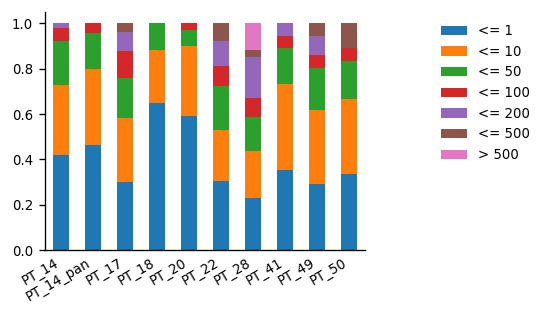

In [47]:
ir.pl.clonal_expansion(
    mdata["airr"], 
    groupby="sample",
    breakpoints=(1,10,50,100,200,500),  # Asegurar los mismos breakpoints
    normalize=True,
    summarize_by="cell"
)

<Axes: >

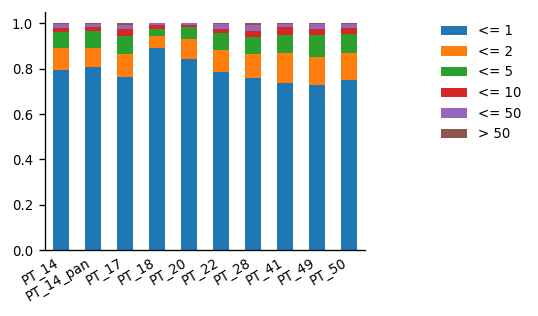

In [49]:
ir.pl.clonal_expansion(
    mdata["airr"], 
    groupby="sample",
    breakpoints=(1,2,5,10,50),  # diferentes breakpoints
    normalize=True,
    summarize_by="clone_id"
)

 ## Estudio de la diversidad clonal:

In [50]:
from scipy.stats import entropy

In [51]:
# Función para calcular el Índice de Gini
def gini_index(values):
    """ Calcula el Índice de Gini para una distribución """
    values = np.sort(values)  # Ordenar valores en orden ascendente
    n = len(values)
    cumulative_values = np.cumsum(values)
    return round(1 - (2 * np.sum(cumulative_values) / (n * np.sum(values))) + (1 / n), 2)  # Redondeo a 2 decimales

# Extraer datos relevantes de mdata["airr"].obs
df = mdata["airr"].obs[["sample", "clone_id", "clone_id_size"]].copy()

# Calcular métricas de diversidad por paciente
diversity_metrics = {}
for sample, group in df.groupby("sample"):
    clone_sizes = group["clone_id_size"].values
    proportions = clone_sizes / clone_sizes.sum()  # p_i valores para Shannon y Simpson
    shannon_index = round(entropy(proportions), 3)  # Índice de Shannon redondeado
    simpson_index = round(1 - np.sum(proportions**2), 3)  # Índice de Simpson redondeado
    gini_index_value = gini_index(clone_sizes)  # Índice de Gini redondeado
    
    diversity_metrics[sample] = {
        "Riqueza clonal": len(group["clone_id"].unique()),
        "Shannon": shannon_index,
        "Simpson": simpson_index,
        "Gini": gini_index_value
    }

# Convertir resultados a DataFrame y redondear valores numéricos a 2 decimales
diversity_df = pd.DataFrame.from_dict(diversity_metrics, orient="index")
diversity_df = diversity_df.round(3)  # Asegurar redondeo de todas las columnas

# Ordenar por Gini de mayor a menor
diversity_df = diversity_df.sort_values(by="Gini", ascending=False)

# Mostrar resultados
print(diversity_df)

           Riqueza clonal  Shannon  Simpson  Gini
PT_50                2724    7.207    0.999  0.83
PT_49                2801    7.563    0.999  0.79
PT_41                2222    7.309    0.999  0.75
PT_28                1956    7.692    0.999  0.74
PT_17                2275    7.651    0.999  0.73
PT_14                3041    7.588    0.999  0.73
PT_22                2344    7.766    0.999  0.71
PT_20                4038    7.501    0.999  0.70
PT_14_pan             722    6.267    0.997  0.67
PT_18                 200    4.880    0.988  0.60


Calculamos la frecuencia del clon_id por paciente:

In [52]:
# 🔹 Copiar los datos relevantes
df = mdata["airr"].obs[["sample", "clone_id", "clone_id_size"]].copy()

# 🔹 Sumar todas las células dentro de cada paciente (sample)
total_cells_per_patient = df.groupby("sample")["clone_id_size"].transform("sum")

# 🔹 Calcular la frecuencia de cada clone_id dentro de cada paciente
df["clone_id_freq"] = df["clone_id_size"] / total_cells_per_patient

# 🔹 Agregar esto de vuelta a `mdata["airr"].obs`
mdata["airr"].obs["clone_id_freq"] = df["clone_id_freq"]


In [53]:
# Filtrar solo por el paciente "PT_14_pan" y ordenar por frecuencia del clon de mayor a menor
df_sorted_pt14_pan = df[df["sample"] == "PT_14_pan"].sort_values(by="clone_id_freq", ascending=False)

# Mostrar las primeras 20 filas
print(df_sorted_pt14_pan.head(20))

                                sample clone_id  clone_id_size  clone_id_freq
cell_id                                                                      
CTCGTACAGGTGTGGT-1_PT14_pan  PT_14_pan    14041             55        0.00575
ACAGCTATCACTATTC-1_PT14_pan  PT_14_pan    14041             55        0.00575
TGGCTGGAGGGCTCTC-1_PT14_pan  PT_14_pan    14041             55        0.00575
CGACTTCAGTTAAGTG-1_PT14_pan  PT_14_pan    14041             55        0.00575
TGGGAAGCACACTGCG-1_PT14_pan  PT_14_pan    14041             55        0.00575
CTGTTTAAGTATCGAA-1_PT14_pan  PT_14_pan    14041             55        0.00575
AAGGAGCGTGCAACTT-1_PT14_pan  PT_14_pan    14041             55        0.00575
CTTAACTCACCACGTG-1_PT14_pan  PT_14_pan    14041             55        0.00575
GACGGCTTCTATCCCG-1_PT14_pan  PT_14_pan    14041             55        0.00575
CTGTTTACATGAGCGA-1_PT14_pan  PT_14_pan    14041             55        0.00575
ACGATGTGTGGTCTCG-1_PT14_pan  PT_14_pan    14041             55  

In [54]:
mdata.write("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_intersected.h5mu")

In [55]:
mdata["airr"].obs

,sample,receptor_type,receptor_subtype,chain_pairing,clone_id,clone_id_size,clonal_expansion,clone_id_freq
cell_id,,,,,,,,
AAACCTGAGAAGAAGC-1_PT14,PT_14,TCR,TRA+TRB,single pair,0,32,≤ 50,0.000424
AAACCTGAGGACAGAA-1_PT14,PT_14,TCR,TRA+TRB,single pair,1,1,≤ 1,0.000013
AAACCTGAGTGGAGTC-1_PT14,PT_14,TCR,TRA+TRB,single pair,2,1,≤ 1,0.000013
AAACCTGAGTGTCTCA-1_PT14,PT_14,TCR,TRA+TRB,single pair,3,1,≤ 1,0.000013
AAACCTGCAAACTGTC-1_PT14,PT_14,TCR,TRA+TRB,extra VJ,4,1,≤ 1,0.000013
...,...,...,...,...,...,...,...,...
TTTGTCAGTGTGGCTC-1_PT50,PT_50,TCR,TRA+TRB,single pair,19839,70,≤ 100,0.000237
TTTGTCATCGTGGGAA-1_PT50,PT_50,TCR,TRA+TRB,single pair,19835,241,≤ 500,0.000817
TTTGTCATCTGCTGCT-1_PT50,PT_50,TCR,TRA+TRB,single pair,20128,16,≤ 50,0.000054


In [5]:
# Cargar el archivo .h5mu
file_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_intersected.h5mu"
mdata = mu.read_h5mu(file_path)

# Contar el número de células por paciente en la modalidad GEX y ordenar por nombre de paciente
cell_counts = mdata['gex'].obs['Sample'].value_counts().sort_index()

# Mostrar el resultado
print(cell_counts)

Sample
PT_14        5774
PT_17        5768
PT_20        5759
PT_22        6075
PT_28        6484
PT_18         275
PT_14_pan    1261
PT_41        4632
PT_49        6934
PT_50        6081
Name: count, dtype: int64


In [7]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

In [8]:
import muon as mu
import pandas as pd

# Cargar el archivo .h5mu
file_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_intersected.h5mu"
mdata = mu.read_h5mu(file_path)

# Obtener el número de células por paciente dentro de la capa airr
cell_counts_airr = mdata['airr'].obs['sample'].value_counts()

# Obtener el número de clonotipos únicos (clone_id) por paciente en airr
clonotype_counts_airr = mdata['airr'].obs.groupby('sample')['clone_id'].nunique()

# Combinar ambos resultados en un DataFrame
summary_airr = pd.DataFrame({'Num_Cells': cell_counts_airr, 'Unique_Clonotypes': clonotype_counts_airr}).sort_index()

# Mostrar el resultado
print(summary_airr)


           Num_Cells  Unique_Clonotypes
sample                                 
PT_14           5774               3041
PT_14_pan       1261                722
PT_17           5768               2275
PT_18            275                200
PT_20           5759               4038
PT_22           6075               2344
PT_28           6484               1956
PT_41           4632               2222
PT_49           6934               2801
PT_50           6081               2724
